# UAS - Deep Learning and Optimization
---
Name: Felicia Ferren

Student ID: 2440013071

Class: LA06

Video links:
- Onedrive: https://bit.ly/case-2-explanation-DLO-final 
- YouTube (alternative): https://youtu.be/QtEwq_qhmwo 

## Starter
As a starter, we have to connect colab to gdrive to get our data because our data is in colab.


In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data

Try load the data and see the first five observations. We also try to find out the information of our data.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/dataset.csv")
df.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45414 entries, 0 to 45413
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              45414 non-null  object
 1   content               45414 non-null  object
 2   score                 45414 non-null  int64 
 3   thumbsUpCount         45414 non-null  int64 
 4   reviewCreatedVersion  40367 non-null  object
 5   at                    45414 non-null  object
 6   replyContent          2477 non-null   object
 7   repliedAt             2477 non-null   object
 8   predicted_category    45414 non-null  object
 9   sentiment             45414 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.5+ MB


there are 10 variables in the dataset:
1. reviewId
2. content
3. score
4. thumbsUpCount
5. reviewCreatedVersion
6. at (time)
7. replyContent
8. repliedAt
9. predicted_category
10. sentiment

From the result above we know that the score and sentiment might be categorical variable. So, try changing the datatype into object (or as factor). Then, try seeing the value_counts of each category.

In [ ]:
# change score to categorical
df['score'] = df['score'].astype(object)
df['score'].value_counts() # we found out that there are 5 category in score 

5    32330
4     6294
1     3647
3     1830
2     1313
Name: score, dtype: int64

In [ ]:
# change sentiment to categorical
df['sentiment'] = df['sentiment'].astype(object)
df['sentiment'].value_counts() # we found out that there are 3 category in sentiment, which are "POSITIVE", "NEUTRAL", "NEGATIVE"

POSITIVE    34281
NEUTRAL      5889
NEGATIVE     5244
Name: sentiment, dtype: int64

After further examination, we see that score ranges from 1–5 and sentiment is categorized as "POSITIVE", "NEUTRAL", or "NEGATIVE", but for right now we’ll just focus on the **content** column for data preprocessing.

## Build Data Processing Pipeline

Sentiment analysis for text data combined natural language processing (NLP) and machine learning (or deep learning) techniques to assign weighted sentiment scores to the systems, topics, or categories within a sentence or document. In business setting, sentiment analysis is extremely helpful as it can help understand customer experiences, gauge public opinion, and monitor brand and product reputation.

the steps used to complete preprocessing our data were:
1. Make text lowercase
2. Remove punctuation
3. Remove emoji’s
4. Remove stopwords
5. Lemmatization

these steps are crucial to be done, because it will make the `content` variable (or text data) clean which will impact when we train our model (effects on the performance of sentiment analysis).

In [ ]:
# import libraries needed
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


initialize Spacy ‘en_core_web_sm’ model, keeping only the component need for lemmatization and creating an engine:

In [ ]:
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

The first pre-processing step we'll do is transform all contents in content column into lower case and create a new column new_content.

In [ ]:
# make text lowercase
df['new_content'] = df['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['new_content'].head()

0                                                 woww
1                  let me know more details about this
2    i've been using this for a while and there's a...
3                                                 good
4                                               mjkobe
Name: new_content, dtype: object

Then, we remove punctuation:

In [ ]:
# remove punctuatiom
df['new_content'] = df['new_content'].str.replace('[^\w\s]','')
df['new_content'].head()

<ipython-input-9-a6d6a7e13635>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_content'] = df['new_content'].str.replace('[^\w\s]','')


0                                                 woww
1                  let me know more details about this
2    ive been using this for a while and theres a b...
3                                                 good
4                                               mjkobe
Name: new_content, dtype: object

After that, we remove emojis (by using function by Kamil Slowikowski) and apply it to new_content.

In [ ]:
# remove emojis
# REFERENCE : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['new_content'] = df['new_content'].apply(lambda x: remove_emoji(x))

Next, we still have some words that we should remove, which are the stopwords.
> Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.

In [ ]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english') # the stopwords must be downloaded first from the nlkt corpus
df['new_content'] = df['new_content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head(10)

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment,new_content
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL,woww
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL,let know details
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE,ive using theres basic bug still fixed scrolli...
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE,good
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL,mjkobe
5,738e80f5-ecb7-4489-bd01-fdf9f84cc7d4,good,2,0,4.5.1143533,2022-08-15 20:05:47,NaN,NaN,USER_EXPERIENCE,POSITIVE,good
6,f190d2a9-b627-4839-ab4a-4b0da9ad260c,awesome for me who likes to read about differe...,5,0,4.5.1143533,2022-08-15 19:29:54,NaN,NaN,CONTENT,POSITIVE,awesome likes read different topics great work...
7,015ff161-7372-4bea-a0df-2e7402d1d287,best thing i discovered in my life. that's is ...,5,0,4.5.1143533,2022-08-15 17:44:17,NaN,NaN,USER_EXPERIENCE,POSITIVE,best thing discovered life thats calls natures...
8,48c50ab1-3097-4e27-bb49-15ad818e2c66,good project,5,0,4.5.1143533,2022-08-15 16:45:30,NaN,NaN,USER_EXPERIENCE,POSITIVE,good project
9,f2b514ba-27c4-49da-8831-ddbd9c67287f,"basic search functionality is non existent, no...",1,0,4.5.1143533,2022-08-15 15:46:29,NaN,NaN,INTERFACE,NEGATIVE,basic search functionality non existent result...


Lastly, we will implement lemmatization using Spacy so that we can count the appearance of each word. 
> Lemmatization removes the grammar tense and transforms each word into its original form. Another way of converting words to its original form is called stemming. While stemming takes the linguistic root of a word, lemmatization is taking a word into its original lemma. For example, if we performed stemming on the word “apples”, the result would be “appl”, whereas lemmatization would give us “apple”.
 
That's why we choose lemmatization over stemming.

In [ ]:
# lemmatization
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
df['new_content']= df['new_content'].apply(space)
df.head(10)

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment,new_content
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL,woww
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL,let know detail
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE,I ve use there s basic bug still fix scroll ar...
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE,good
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL,mjkobe
5,738e80f5-ecb7-4489-bd01-fdf9f84cc7d4,good,2,0,4.5.1143533,2022-08-15 20:05:47,NaN,NaN,USER_EXPERIENCE,POSITIVE,good
6,f190d2a9-b627-4839-ab4a-4b0da9ad260c,awesome for me who likes to read about differe...,5,0,4.5.1143533,2022-08-15 19:29:54,NaN,NaN,CONTENT,POSITIVE,awesome like read different topic great work d...
7,015ff161-7372-4bea-a0df-2e7402d1d287,best thing i discovered in my life. that's is ...,5,0,4.5.1143533,2022-08-15 17:44:17,NaN,NaN,USER_EXPERIENCE,POSITIVE,good thing discover life that s call nature gi...
8,48c50ab1-3097-4e27-bb49-15ad818e2c66,good project,5,0,4.5.1143533,2022-08-15 16:45:30,NaN,NaN,USER_EXPERIENCE,POSITIVE,good project
9,f2b514ba-27c4-49da-8831-ddbd9c67287f,"basic search functionality is non existent, no...",1,0,4.5.1143533,2022-08-15 15:46:29,NaN,NaN,INTERFACE,NEGATIVE,basic search functionality non existent result...


By finisihing the process, now our text is ready for the analysis. We could save the new dataset so we dont have to re-run the preprocessing next time.

In [ ]:
%mkdir gdrive/MyDrive/sentiment-analysis
%cd gdrive/MyDrive/sentiment-analysis
df.to_csv('new_dataset.csv', index=False)

/content/gdrive/MyDrive/sentiment-analysis


## Develop Model

In order to implement Deep Belief Network (DBN), we need to implement a class for the Restricted Boltzmann Machine (RBM) (because DBM is built under the Boltzmann Machine). This time, we will implement code from https://github.com/albertbup/deep-belief-network/. 

we run the codes below to connect with gdrive, import the new dataset using pandas, set our working directory, and clone the project codes from github.

### Preparations

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/sentiment-analysis/new_dataset.csv")

In [ ]:
%cd /content/gdrive/MyDrive/sentiment-analysis

/content/gdrive/MyDrive/sentiment-analysis


In [ ]:
!git clone https://github.com/albertbup/deep-belief-network.git

fatal: destination path 'deep-belief-network' already exists and is not an empty directory.


In [ ]:
%cd deep-belief-network

/content/gdrive/MyDrive/sentiment-analysis/deep-belief-network


then, it is required to install these requirements filled with the version of libraries used in this project, so that the codes could run.

In [ ]:
# install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0

then we import the libraries needed and set seed for reproducibility.

In [ ]:
# import libraries needed
from dbn.tensorflow import SupervisedDBNClassification
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report


np.random.seed(40)  # for reproducibility

we are going to analyze the content against the sentiment categorization, which means we will take `new_content` as our predictor (X) and `sentiment` as our target variable (y).

In [ ]:
X = np.array(df["new_content"])
y = np.array(df["sentiment"])

then, we do the splitting process using train_test_split, and the test size is 0.2 of overall data.

In [ ]:
# split into train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Tokenization

before we get to the training, we need to do tokenization. 

keras Tokenizer takes all the unique words in the corpus and forms a dictionary with words as keys and their number of occurences as values.  then, it sorts the dictionary in descending order of counts. then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.

In [ ]:
from keras.preprocessing import sequence, text
from keras.utils import pad_sequences

# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

### Training

Now, we can continue to the training process.

In [ ]:
# Training
# we use SupervisedDBNClassification classifier because our case is a classification class (3 class to be precise), 
# and there are labels in the data, so it is a supervised case.
classifier = SupervisedDBNClassification(hidden_layers_structure=[256, 256],
                                         learning_rate_rbm=0.05,
                                         learning_rate=0.1,
                                         n_epochs_rbm=10,
                                         n_iter_backprop=100,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.2)

In [ ]:
# fit our model with training data
classifier.fit(xtrain_pad, y_train)

Instructions for updating:
Use `tf.cast` instead.


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 105618752294046121984.000000
>> Epoch 2 finished 	RBM Reconstruction error 123984420234031513600.000000
>> Epoch 3 finished 	RBM Reconstruction error 112212136088460951552.000000
>> Epoch 4 finished 	RBM Reconstruction error 136114395088854302720.000000
>> Epoch 5 finished 	RBM Reconstruction error 235183194931854049280.000000
>> Epoch 6 finished 	RBM Reconstruction error 254255094751232491520.000000
>> Epoch 7 finished 	RBM Reconstruction error 359223401089044381696.000000
>> Epoch 8 finished 	RBM Reconstruction error 471944284173307150336.000000
>> Epoch 9 finished 	RBM Reconstruction error 419223970257747050496.000000
>> Epoch 10 finished 	RBM Reconstruction error 355793925100940361728.000000


/content/gdrive/MyDrive/sentiment-analysis/deep-belief-network/dbn/models.py:220: RuntimeWarning: overflow encountered in square
  return np.mean(np.sum((data_reconstructed - data) ** 2, 1))
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


>> Epoch 1 finished 	RBM Reconstruction error inf
>> Epoch 2 finished 	RBM Reconstruction error inf
>> Epoch 3 finished 	RBM Reconstruction error inf
>> Epoch 4 finished 	RBM Reconstruction error inf
>> Epoch 5 finished 	RBM Reconstruction error inf
>> Epoch 6 finished 	RBM Reconstruction error inf
>> Epoch 7 finished 	RBM Reconstruction error inf
>> Epoch 8 finished 	RBM Reconstruction error inf
>> Epoch 9 finished 	RBM Reconstruction error inf


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


>> Epoch 10 finished 	RBM Reconstruction error inf
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss nan
>> Epoch 1 finished 	ANN training loss nan
>> Epoch 2 finished 	ANN training loss nan
>> Epoch 3 finished 	ANN training loss nan
>> Epoch 4 finished 	ANN training loss nan
>> Epoch 5 finished 	ANN training loss nan
>> Epoch 6 finished 	ANN training loss nan
>> Epoch 7 finished 	ANN training loss nan
>> Epoch 8 finished 	ANN training loss nan
>> Epoch 9 finished 	ANN training loss nan
>> Epoch 10 finished 	ANN training loss nan
>> Epoch 11 finished 	ANN training loss nan
>> Epoch 12 finished 	ANN training loss nan
>> Epoch 13 finished 	ANN training loss nan
>> Epoch 14 finished 	ANN training loss nan
>> Epoch 15 finished 	ANN training loss nan
>> Epoch 16 finished 	ANN training loss nan
>> Epoch 17 finished 	ANN training loss nan
>> Epoch 18 finished 	ANN training loss nan
>> Epoch 19 finished 	ANN training loss nan
>> Epoch 20 finished 	ANN tra

SupervisedDBNClassification(batch_size=32, dropout_p=0.2,
                            idx_to_label_map={0: 'POSITIVE', 1: 'NEUTRAL',
                                              2: 'NEGATIVE'},
                            l2_regularization=1.0,
                            label_to_idx_map={'NEGATIVE': 2, 'NEUTRAL': 1,
                                              'POSITIVE': 0},
                            learning_rate=0.1, n_iter_backprop=100,
                            verbose=True)

we can see from the RBM Reconstuctor error value is enormous. however, we've done training our model.. let's get to the performance analysis.

## Performance Analysis

Firstly, we will do the prediction for out X validation data.

In [ ]:
# Testing
y_pred = classifier.predict(xvalid_pad)

Then, try to print some performance metrics.

In [ ]:
# Print performace metrics results
print('Done.\nAccuracy: %f' % accuracy_score(y_test, y_pred))
# print('Done.\nClassification Report: %f' % classification_report(y_test, y_pred))
# print('Done.\nPrecision: %f' % precision_score(y_test, y_pred))
# print('Done.\nRecall: %f' % recall_score(y_test, y_pred))
# print('Done.\nF-1 Score: %f' % f1_score(y_test, y_pred))

Done.
Accuracy: 0.744688


Actually, we want to also print the precision, recall, and f-1 score but bcs it's multiclass so we cant (there are 3 classes).

So, we'll make the 3x3 confusion matrix.

In [ ]:
# perform confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# see again the categories in `sentiment` variable 
# we acknowledge that it's considered as imbalanced data.
df['sentiment'].value_counts()

POSITIVE    34281
NEUTRAL      5889
NEGATIVE     5244
Name: sentiment, dtype: int64

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['POSITIVE','NEUTRAL','NEGATIVE'], 
                     columns = ['POSITIVE','NEUTRAL','NEGATIVE'])

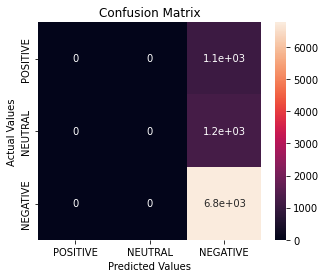

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


## Conclusion

The accuracy score for this model is 0.7447 or 74.47% which is quite good. However, when we display the confusion matrix, our model only can determine the NEGATIVE sentiment which means that our model is not good enough to determine the other two categories. 

In this case, we face the imbalanced classification data -- so we need to fix/improve our current model in order to enhance the performance. 

references:
- https://towardsdatascience.com/cleaning-preprocessing-text-data-for-sentiment-analysis-382a41f150d6 
- https://github.com/albertbup/deep-belief-network/ 
- https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#Attention-Models

### CODE DI BAWAH TIDAK DIPAKAI!!!

In [ ]:
# # tokenizer
# from torchtext.data.utils import get_tokenizer 
# tokenizer = get_tokenizer("basic_english") # we use basic english tokenizer

# # for testing purpose
# tokens = tokenizer("You can now install TorchText using pip!")
# tokens

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']

In [ ]:
# from torchtext.vocab import build_vocab_from_iterator 
# from torchtext.data.utils import get_tokenizer 

# tokenizer = get_tokenizer("basic_english") 

# def yield_tokens(data_iter): 
#   for _, content in range(data_iter): 
#     yield tokenizer(content) 

# def get_vocab(train_datapipe): 
#   vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), 
#                                     specials=['<UNK>', '<PAD>'], 
#                                     max_tokens=20000) 
#   vocab.set_default_index(vocab['<UNK>']) 
#   return vocab 

# vocab = get_vocab(data)

NameError: ignored

In [ ]:
# # RBM
# import numpy as np
# import torch
# import random
# from tqdm import trange

# class RBM:

# 	def __init__(self, n_visible, n_hidden, lr=0.001, epochs=5, mode='bernoulli', batch_size=32, k=3, optimizer='adam', gpu=False, savefile=None, early_stopping_patience=5):
# 		self.mode = mode # bernoulli or gaussian RBM
# 		self.n_hidden = n_hidden #  Number of hidden nodes
# 		self.n_visible = n_visible # Number of visible nodes
# 		self.lr = lr # Learning rate for the CD algorithm
# 		self.epochs = epochs # Number of iterations to run the algorithm for
# 		self.batch_size = batch_size
# 		self.k = k
# 		self.optimizer = optimizer
# 		self.beta_1=0.9
# 		self.beta_2=0.999
# 		self.epsilon=1e-07
# 		self.m = [0, 0, 0]
# 		self.v = [0, 0, 0]
# 		self.m_batches = {0:[], 1:[], 2:[]}
# 		self.v_batches = {0:[], 1:[], 2:[]}
# 		self.savefile = savefile
# 		self.early_stopping_patience = early_stopping_patience
# 		self.stagnation = 0
# 		self.previous_loss_before_stagnation = 0
# 		self.progress = []

# 		if torch.cuda.is_available() and gpu==True:  
# 			dev = "cuda:0" 
# 		else:  
# 			dev = "cpu"  
# 		self.device = torch.device(dev)

# 		# Initialize weights and biases
# 		std = 4 * np.sqrt(6. / (self.n_visible + self.n_hidden))
# 		self.W = torch.normal(mean=0, std=std, size=(self.n_hidden, self.n_visible))
# 		self.vb = torch.zeros(size=(1, self.n_visible), dtype=torch.float32)
# 		self.hb = torch.zeros(size=(1, self.n_hidden), dtype=torch.float32)

# 		self.W = self.W.to(self.device)
# 		self.vb = self.vb.to(self.device)
# 		self.hb = self.hb.to(self.device)
		
# 	def sample_h(self, x):
# 		wx = torch.mm(x, self.W.t())
# 		activation = wx + self.hb
# 		p_h_given_v = torch.sigmoid(activation)
# 		if self.mode == 'bernoulli':
# 			return p_h_given_v, torch.bernoulli(p_h_given_v)
# 		else:
# 			return p_h_given_v, torch.add(p_h_given_v, torch.normal(mean=0, std=1, size=p_h_given_v.shape))

# 	def sample_v(self, y):
# 		wy = torch.mm(y, self.W)
# 		activation = wy + self.vb
# 		p_v_given_h =torch.sigmoid(activation)
# 		if self.mode == 'bernoulli':
# 			return p_v_given_h, torch.bernoulli(p_v_given_h)
# 		else:
# 			return p_v_given_h, torch.add(p_v_given_h, torch.normal(mean=0, std=1, size=p_v_given_h.shape))
	
# 	def adam(self, g, epoch, index):
# 		self.m[index] = self.beta_1 * self.m[index] + (1 - self.beta_1) * g
# 		self.v[index] = self.beta_2 * self.v[index] + (1 - self.beta_2) * torch.pow(g, 2)

# 		m_hat = self.m[index] / (1 - np.power(self.beta_1, epoch)) + (1 - self.beta_1) * g / (1 - np.power(self.beta_1, epoch))
# 		v_hat = self.v[index] / (1 - np.power(self.beta_2, epoch))
# 		return m_hat / (torch.sqrt(v_hat) + self.epsilon)

# 	def update(self, v0, vk, ph0, phk, epoch):
# 		dW = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
# 		dvb = torch.sum((v0 - vk), 0)
# 		dhb = torch.sum((ph0 - phk), 0)

# 		if self.optimizer == 'adam':
# 			dW = self.adam(dW, epoch, 0)
# 			dvb = self.adam(dvb, epoch, 1)
# 			dhb = self.adam(dhb, epoch, 2)

# 		self.W += self.lr * dW
# 		self.vb += self.lr * dvb
# 		self.hb += self.lr * dhb

# 	def train(self, dataset):
# 		dataset = dataset.to(self.device)
# 		learning = trange(self.epochs, desc=str('Starting...'))
# 		for epoch in learning:
# 			train_loss = 0
# 			counter = 0
# 			for batch_start_index in range(0, dataset.shape[0]-self.batch_size, self.batch_size):
# 				vk = dataset[batch_start_index:batch_start_index+self.batch_size]
# 				v0 = dataset[batch_start_index:batch_start_index+self.batch_size]
# 				ph0, _ = self.sample_h(v0)

# 				for k in range(self.k):
# 					_, hk = self.sample_h(vk)
# 					_, vk = self.sample_v(hk)
# 				phk, _ = self.sample_h(vk)
# 				self.update(v0, vk, ph0, phk, epoch+1)
# 				train_loss += torch.mean(torch.abs(v0-vk))
# 				counter += 1
			
# 			self.progress.append(train_loss.item()/counter)
# 			details = {'epoch': epoch+1, 'loss': round(train_loss.item()/counter, 4)}
# 			learning.set_description(str(details))
# 			learning.refresh()
			
# 			if train_loss.item()/counter > self.previous_loss_before_stagnation and epoch>self.early_stopping_patience+1:
# 				self.stagnation += 1
# 				if self.stagnation == self.early_stopping_patience-1:
# 					learning.close()
# 					print("Not Improving the stopping training loop.")
# 					break
# 			else:
# 				self.previous_loss_before_stagnation = train_loss.item()/counter
# 				self.stagnation = 0
# 		learning.close()
# 		if self.savefile is not None:
# 			model = {'W':self.W, 'vb':self.vb, 'hb':self.hb}
# 			torch.save(model, self.savefile)

# 	def load_rbm(self, savefile):
# 		loaded = torch.load(savefile)
# 		self.W = loaded['W']
# 		self.vb = loaded['vb']
# 		self.hb = loaded['hb']

# 		self.W = self.W.to(self.device)
# 		self.vb = self.vb.to(self.device)
# 		self.hb = self.hb.to(self.device)



# def trial_dataset():
# 	dataset = []
# 	for _ in range(1000):
# 		t = []
# 		for _ in range(10):
# 			if random.random()>0.75:
# 				t.append(0)
# 			else:
# 				t.append(1)
# 		dataset.append(t)

# 	for _ in range(1000):
# 		t = []
# 		for _ in range(10):
# 			if random.random()>0.75:
# 				t.append(1)
# 			else:
# 				t.append(0)
# 		dataset.append(t)

# 	dataset = np.array(dataset, dtype=np.float32)
# 	np.random.shuffle(dataset)
# 	dataset = torch.from_numpy(dataset)
# 	return dataset

# if __name__ == '__main__':
	
# 	dataset = trial_dataset()

# 	rbm = RBM(10, 100, epochs=50, mode='bernoulli', lr=0.001, optimizer='adam', gpu=True, savefile='save_example.pt', early_stopping_patience=50)
# 	print("Before Training:", rbm.vb)
# 	rbm.train(dataset)
# 	print("After Training:", rbm.vb)
# 	rbm.load_rbm('save_example.pt')
# 	print("After Loading:", rbm.vb)

# # REFS: https://github.com/AmanPriyanshu/Deep-Belief-Networks-in-PyTorch/blob/main/RBM.py

Before Training: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


{'epoch': 50, 'loss': 0.1536}: 100%|██████████| 50/50 [00:05<00:00,  8.83it/s]

After Training: tensor([[-0.1857, -0.2325, -0.1848, -0.1971, -0.2438, -0.1412, -0.2146, -0.1462,
         -0.2540, -0.3161]])
After Loading: tensor([[-0.1857, -0.2325, -0.1848, -0.1971, -0.2438, -0.1412, -0.2146, -0.1462,
         -0.2540, -0.3161]])


In [ ]:
# # DBN
# import numpy as np
# import torch
# import random
# from tqdm import trange

# class DBN:
# 	def __init__(self, input_size, layers, mode='bernoulli', gpu=False, k=5, savefile=None):
# 		self.layers = layers
# 		self.input_size = input_size
# 		self.layer_parameters = [{'W':None, 'hb':None, 'vb':None} for _ in range(len(layers))]
# 		self.k = k
# 		self.mode = mode
# 		self.savefile = savefile

# 	def sample_v(self, y, W, vb):
# 		wy = torch.mm(y, W)
# 		activation = wy + vb
# 		p_v_given_h =torch.sigmoid(activation)
# 		if self.mode == 'bernoulli':
# 			return p_v_given_h, torch.bernoulli(p_v_given_h)
# 		else:
# 			return p_v_given_h, torch.add(p_v_given_h, torch.normal(mean=0, std=1, size=p_v_given_h.shape))

# 	def sample_h(self, x, W, hb):
# 		wx = torch.mm(x, W.t())
# 		activation = wx + hb
# 		p_h_given_v = torch.sigmoid(activation)
# 		if self.mode == 'bernoulli':
# 			return p_h_given_v, torch.bernoulli(p_h_given_v)
# 		else:
# 			return p_h_given_v, torch.add(p_h_given_v, torch.normal(mean=0, std=1, size=p_h_given_v.shape))

# 	def generate_input_for_layer(self, index, x):
# 		if index>0:
# 			x_gen = []
# 			for _ in range(self.k):
# 				x_dash = x.clone()
# 				for i in range(index):
# 					_, x_dash = self.sample_h(x_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['hb'])
# 				x_gen.append(x_dash)

# 			x_dash = torch.stack(x_gen)
# 			x_dash = torch.mean(x_dash, dim=0)
# 		else:
# 			x_dash = x.clone()
# 		return x_dash

# 	def train_DBN(self, x):
# 		for index, layer in enumerate(self.layers):
# 			if index==0:
# 				vn = self.input_size
# 			else:
# 				vn = self.layers[index-1]
# 			hn = self.layers[index]

# 			rbm = RBM(vn, hn, epochs=100, mode='bernoulli', lr=0.0005, k=10, batch_size=128, gpu=True, optimizer='adam', early_stopping_patience=10)
# 			x_dash = self.generate_input_for_layer(index, x)
# 			rbm.train(x_dash)
# 			self.layer_parameters[index]['W'] = rbm.W.cpu()
# 			self.layer_parameters[index]['hb'] = rbm.hb.cpu()
# 			self.layer_parameters[index]['vb'] = rbm.vb.cpu()
# 			print("Finished Training Layer:", index, "to", index+1)
# 		if self.savefile is not None:
# 			torch.save(self.layer_parameters, self.savefile)

# 	def reconstructor(self, x):
# 		x_gen = []
# 		for _ in range(self.k):
# 			x_dash = x.clone()
# 			for i in range(len(self.layer_parameters)):
# 				_, x_dash = self.sample_h(x_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['hb'])
# 			x_gen.append(x_dash)
# 		x_dash = torch.stack(x_gen)
# 		x_dash = torch.mean(x_dash, dim=0)

# 		y = x_dash

# 		y_gen = []
# 		for _ in range(self.k):
# 			y_dash = y.clone()
# 			for i in range(len(self.layer_parameters)):
# 				i = len(self.layer_parameters)-1-i
# 				_, y_dash = self.sample_v(y_dash, self.layer_parameters[i]['W'], self.layer_parameters[i]['vb'])
# 			y_gen.append(y_dash)
# 		y_dash = torch.stack(y_gen)
# 		y_dash = torch.mean(y_dash, dim=0)

# 		return y_dash, x_dash

# 	def initialize_model(self):
# 		print("The Last layer will not be activated. The rest are activated using the Sigoid Function")
# 		modules = []
# 		for index, layer in enumerate(self.layer_parameters):
# 			modules.append(torch.nn.Linear(layer['W'].shape[1], layer['W'].shape[0]))
# 			if index < len(self.layer_parameters) - 1:
# 				modules.append(torch.nn.Sigmoid())
# 		model = torch.nn.Sequential(*modules)

# 		for layer_no, layer in enumerate(model):
# 			if layer_no//2 == len(self.layer_parameters)-1:
# 				break
# 			if layer_no%2 == 0:
# 				model[layer_no].weight = torch.nn.Parameter(self.layer_parameters[layer_no//2]['W'])
# 				model[layer_no].bias = torch.nn.Parameter(self.layer_parameters[layer_no//2]['hb'])

# 		return model

# def trial_dataset():
# 	dataset = []
# 	for _ in range(1000):
# 		t = []
# 		for _ in range(10):
# 			if random.random()>0.75:
# 				t.append(0)
# 			else:
# 				t.append(1)
# 		dataset.append(t)

# 	for _ in range(1000):
# 		t = []
# 		for _ in range(10):
# 			if random.random()>0.75:
# 				t.append(1)
# 			else:
# 				t.append(0)
# 		dataset.append(t)

# 	dataset = np.array(dataset, dtype=np.float32)
# 	np.random.shuffle(dataset)
# 	dataset = torch.from_numpy(dataset)
# 	return dataset

# # REFS: https://github.com/AmanPriyanshu/Deep-Belief-Networks-in-PyTorch/blob/main/DBN.py

In [ ]:
# import math
# import tensorflow as tf
# import numpy as np

# # class that defines the behavior of the RBM
# class RBM(object):
#   def __init__(self, input_size, output_size):
#     # defining the hyperparameters
#     self._input_size = input_size
#     self._output_size = output_size
#     self.epochs = 5
#     self.learning_rate = 0.01
#     self.batchsize = 64

#     # initializing weights and biases as matrices full of zeroes
#     self.w = np.zeros([input_size, output_size], np.float32)
#     self.hb = np.zeros([output_size], np.float32) # hidden biases
#     self.vb = np.zeros([input_size], np.float32)

#   # fits the result from the weighted visible layer plus the bias into sigmoid curve



In [ ]:
url_dbn = 'https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm,
}

for file, url in utils.items():
    ! wget -O {file} {url} {file}

--2023-02-06 19:53:41--  https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/DBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5973 (5.8K) [text/plain]
Saving to: ‘DBN.py’

DBN.py              100%[===================>]   5.83K  --.-KB/s    in 0.001s  

2023-02-06 19:53:41 (5.79 MB/s) - ‘DBN.py’ saved [5973/5973]

--2023-02-06 19:53:41--  http://dbn.py/
Resolving dbn.py (dbn.py)... failed: Name or service not known.
wget: unable to resolve host address ‘dbn.py’
FINISHED --2023-02-06 19:53:41--
Total wall clock time: 0.2s
Downloaded: 1 files, 5.8K in 0.001s (5.79 MB/s)
--2023-02-06 19:53:41--  https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 1

In [ ]:
import numpy as np
import torch
import torchvision as tv
import tqdm
from DBN import DBN
import matplotlib.pyplot as plt
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix
import scipy.cluster as cluster
import seaborn as sns
import math
import sklearn
from skimage.util import random_noise

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

False


In [ ]:
classifier = DBN(visible_units=1,
                hidden_units=[400, 600],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 10
batch_size = 32

In [ ]:
# Training

classifier.train_static(
    X_train,
    y_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1


AttributeError: ignored